In [214]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.interpolate import interp1d
import seaborn as sns
import os
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import mean_absolute_error, mean_squared_error, silhouette_score
import pickle
from scipy.stats import ttest_rel, wilcoxon, pearsonr, spearmanr, kendalltau
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer 
PowerTransformer

# Import necessary libraries for clustering and silhouette score calculation
from sklearn.cluster import KMeans

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from PlottingFunctions import *
from dict_types import dict_types

## Read dataframe of results for all gauges

In [215]:
all_events =[]
for file in os.listdir("../DanishRainData_Outputs/5mins/"):
    df = pd.read_csv(f"../DanishRainData_Outputs/5mins/{file}")
    df['event_num']=range(0, len(df))
    all_events.append(df)
all_events_df = pd.concat(all_events)   

/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/ukcp18/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (143) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/ukcp18/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (83,143) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


### Remove events which are too small

In [216]:
print(len(all_events_df))
all_events_df = all_events_df[all_events_df['total_precip']>4].copy()
print(len(all_events_df))

539546
516453


### Remove normalisations we're not interested in (rn)

In [217]:
print(len(all_events_df.columns))
columns_to_drop = [col for col in all_events_df.columns if '_norm' in col or '_dblnorm' in col or 'DMC_100' in col]
all_events_df.drop(columns=columns_to_drop, inplace=True)
print(len(all_events_df.columns))

189
129


In [218]:
all_events_df.reset_index(inplace=True, drop=True)

### Remove columns we're not interested in (rn)

In [219]:
# del all_events_df['min_intensity']
del all_events_df['BSC']
del all_events_df['duration']
del all_events_df['total_precip']
# del all_events_df['BSC_DMC']
# del all_events_df['mean_intensity_DMC']
# del all_events_df['min_intensity_DMC']

### Delete problematic (np.nan) columns

NameError: name 'skew' is not defined

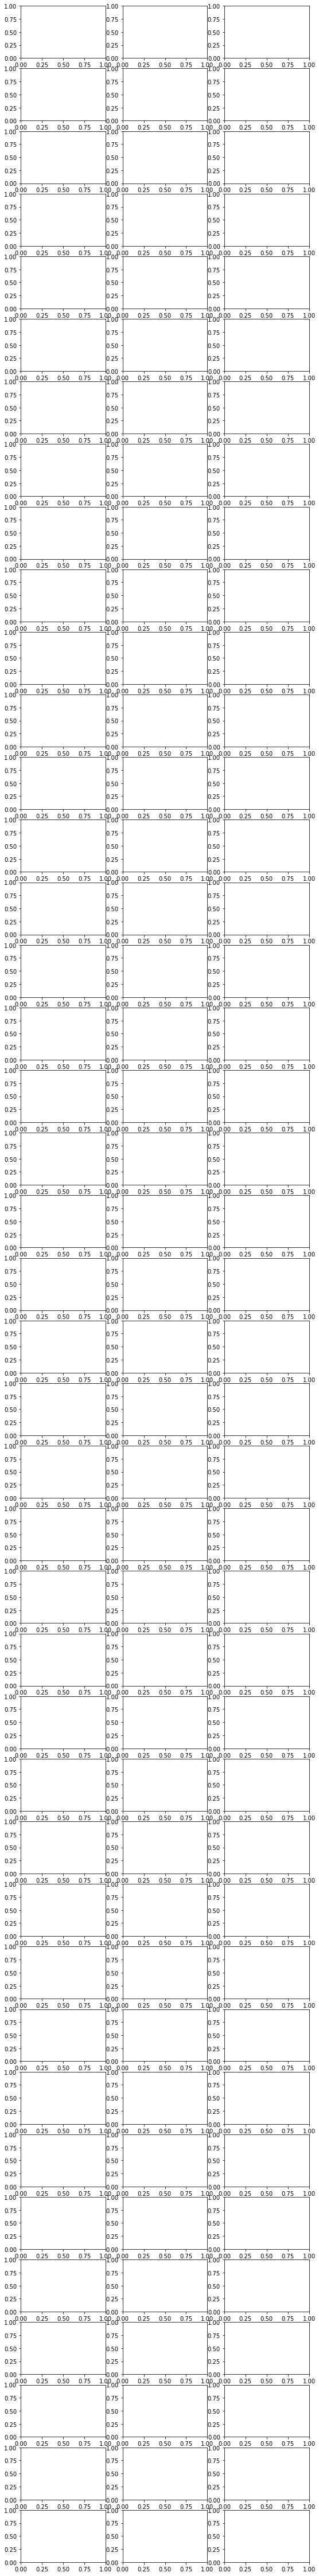

In [222]:
def plot_metric_histograms(df, columns=None, bins=30, skew_threshold=1.0):
    """
    Plots histograms for each metric column with skewness displayed.
    If no columns provided, uses all numeric columns.
    """
    if columns is None:
        columns = df.select_dtypes(include='number').columns

    n_cols = 3
    n_rows = int(np.ceil(len(columns) / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*3, n_rows*2))
    axes = axes.flatten()

    for i, col in enumerate(columns):
        data = df[col].dropna()
        sk = skew(data)
        sns.histplot(data, bins=bins, kde=True, ax=axes[i])
        axes[i].set_title(f"{col}\nSkewness: {sk:.2f}")
        axes[i].set_xlabel('')
        axes[i].set_ylabel('')

    # Turn off unused axes
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()
    
plot_metric_histograms(all_events_df)

In [62]:
cols_to_keep = all_events_df.columns
cols_to_del = ['frac_q1', 'frac_q2', 'frac_q3', 'frac_q4',
                   'frac_q1_DMC_10', 'frac_q2_DMC_10', 'frac_q3_DMC_10', 'frac_q4_DMC_10', 
              '% time HIZ', '% time LIZ', '% rain HIZ', 'Mean Intensity HIZ',
              '% time LIZ_DMC_10', '% rain HIZ_DMC_10', 'Mean Intensity HIZ_DMC_10',
              'frac_time_in_high_intensity_zone', 'frac_time_in_low_intensity_zone', 'frac_rain_in_high_intensity_zone',
               'mean_intensity_high_intensity_zone', 'frac_time_in_high_intensity_zone_DMC_10', 
               'frac_time_in_low_intensity_zone_DMC_10', 'frac_rain_in_high_intensity_zone_DMC_10', 
               'mean_intensity_high_intensity_zone_DMC_10',
              'heaviest_half', 'heaviest_half_DMC_10',
              'frac_q2_wi_', 'frac_q3_wi_', 'peak_mean_ratio_scaled', "3rd_com",
              "min_intensity", 'BSC_Index']

cols_to_keep = [x for x in cols_to_keep if x not in cols_to_del]  

all_events_df = all_events_df[cols_to_keep]

In [60]:
# Find columns with nan for 60 mins
columns_with_nan = all_events_df.columns[all_events_df.isnull().any()].tolist()
print("Columns with at least one NaN value:")
print(columns_with_nan)

Columns with at least one NaN value:
[]


In [39]:
# # # Find indices of rows with any NaNs in the 60-minute data
# bad_indices = all_events_df[all_events_df.isnull().any(axis=1)].index
# len(bad_indices)
# # Drop rows at these indices from all dataframes
# all_events_df = all_events_df.drop(index=bad_indices)

# del all_events_df['event_num']
# all_events_df.reset_index(drop=True, inplace=True)

# # Recheck for NANS
# columns_with_nan = all_events_df.columns[all_events_df.isnull().any()].tolist()
# print("Columns with at least one NaN value:")
# print(columns_with_nan)

### Split data into different subsets

In [63]:
raw_cols = []
for col in all_events_df.columns:
    if not col.endswith('_DMC_10') and col not in ['gauge_num', 'event_num']:
        raw_cols.append(col)
all_events_df_raw = all_events_df[raw_cols]

dmc_cols = []
for col in all_events_df.columns:
    if col.endswith('_DMC_10') and col not in ['frac_q1_DMC_10','frac_q2_DMC_10', 'frac_q3_DMC_10', 'frac_q4_DMC_10']:
        dmc_cols.append(col)
all_events_df_dmc = all_events_df[dmc_cols]

asymmetry_cols = []
for col in all_events_df.columns:
     if col in ['m3','m4', 'm5', 'D50', 'T25', 'T75', 'centre_gravity_interpolated', 'time_skewness', 'time_kurtosis',
               '3rd_com', '3rd_ARR', 'Event_Loading', 'lorentz_asymmetry', 'BSC_index']:
        asymmetry_cols.append(col)
all_events_df_asymmetry = all_events_df[asymmetry_cols]


peakiness_cols = []
for col in all_events_df.columns:
     if col in ['peak_mean_ratio', 'kurtosis', 'skewness', 'sd', "cv", 'NRMSE_P']:
        peakiness_cols.append(col)
all_events_df_peakiness = all_events_df[peakiness_cols]


concentration_cols = []
for col in all_events_df.columns:
     if col in ['TCI', 'PCI', 'gini', '% time HIZ', "% time LIZ", '% rain HIZ']:
        concentration_cols.append(col)
all_events_df_concentration = all_events_df[concentration_cols]

In [64]:
all_events_df_reordered = all_events_df[['m3','m4', 'm5', 'D50', 'T25', 'T75','centre_gravity_interpolated', 
                   'time_skewness', 'time_kurtosis',
               '3rd_ARR',  'lorentz_asymetry',  'peak_mean_ratio',  'kurtosis', 'skewness', 'std', "cv", 'NRMSE_P',
              'TCI', 'PCI', 'gini',]]

In [195]:
correlation_matrix_raw = all_events_df_raw.corr(method='spearman')
correlation_matrix_dmc = all_events_df_dmc.corr()
correlation_matrix_asymmetry = all_events_df_asymmetry.corr()
correlation_matrix_peakiness = all_events_df_peakiness.corr()
correlation_matrix_concentration =  all_events_df_concentration.corr()
correlation_matrix_reordered  =  all_events_df_reordered.corr()

### Hierarchical clustering

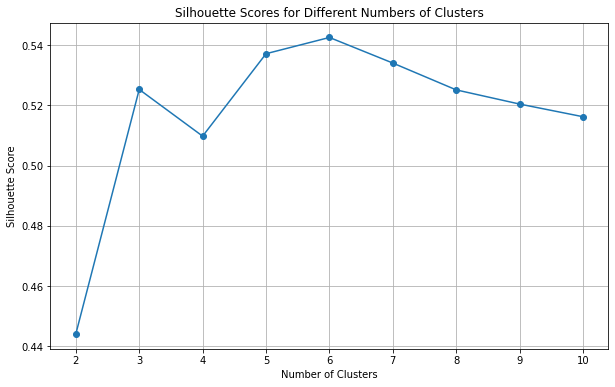

In [196]:
# Prepare to calculate silhouette scores for different numbers of clusters
range_n_clusters = range(2, 11)  # Testing from 2 to 10 clusters
silhouette_scores = []

# Calculate silhouette scores for each number of clusters
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(correlation_matrix_raw)
    silhouette_avg = silhouette_score(correlation_matrix_raw, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot the silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.title('Silhouette Scores for Different Numbers of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.xticks(range_n_clusters)
plt.grid(True)
plt.show()

In [178]:
def cluster_from_correlation1(corr_matrix, num_clusters=4, plot_dendrogram=True, ax=ax, orientation ='left', color_threshold = 0.9):

    # Convert correlation matrix to distance matrix
    distance_matrix = 1 - np.abs(corr_matrix)
    distance_matrix = np.clip(distance_matrix, 0, 1)

    # Convert to condensed form for linkage
    condensed_dist = squareform(distance_matrix)

    # Perform hierarchical clustering
    Z = linkage(condensed_dist, method='complete')

    # Determine cluster labels
    labels = fcluster(Z, num_clusters, criterion='maxclust')
    cluster_series = pd.Series(labels, index=corr_matrix.columns, name='Cluster')

    if plot_dendrogram:
        # Compute color threshold to show the correct number of clusters
        distances = sorted(Z[:, 2], reverse=True)
#         if len(distances) >= num_clusters - 1:
#             color_threshold = distances[num_clusters - 1]
#         else:
#             color_threshold = 0.9  # fallback threshold
#         color_threshold = 0.7
        
        # Example column index
        cols = corr_matrix.columns

        # Append matching type from dict_types if exists
        new_cols = pd.Index([
            f"{col} - {dict_types[col]}" if col in dict_types else col
            for col in cols])            
            
        # Plot dendrogram
        dendrogram(
            Z,
            labels=new_cols,
            leaf_rotation=0,
            leaf_font_size=10,
            color_threshold=color_threshold, 
            orientation = orientation,
            ax=ax
        )

    return cluster_series, cols

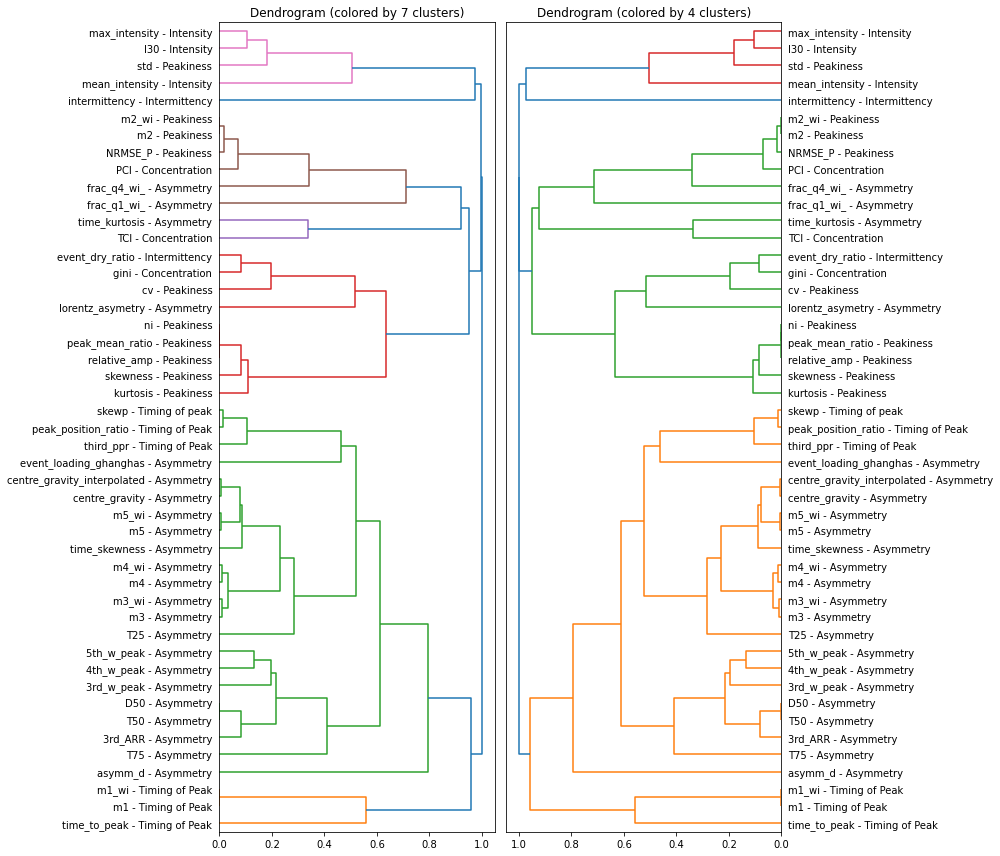

In [179]:
fig,axs=plt.subplots(ncols=2, figsize=(14,12))
clustered, new_cols = cluster_from_correlation1(correlation_matrix_raw, num_clusters=7, plot_dendrogram = True, ax=axs[0], 
                                      orientation = 'right', color_threshold = 0.9)
clustered, new_cols = cluster_from_correlation1(correlation_matrix_raw, num_clusters=4, plot_dendrogram = True, ax=axs[1], 
                                      orientation ='left', color_threshold = 0.97)
axs[0].set_title(f'Dendrogram (colored by 7 clusters)')
axs[1].set_title(f'Dendrogram (colored by 4 clusters)')
plt.tight_layout()
plt.show()

In [134]:
# clustered = cluster_from_correlation1(correlation_matrix_raw, num_clusters=7, plot_dendrogram = True)

In [139]:
clusters = pd.DataFrame(clustered)
# Group by cluster and build the display string
for cluster_id, group in clusters.groupby('Cluster'):
    print(f"\nCluster {cluster_id}:")
    for metric in group.index:
        if metric in dict_types:
            print(f"  {metric} ({dict_types[metric]})")
        else:
            print(f"  {metric}")


Cluster 1:
  time_to_peak (Timing of Peak)
  peak_position_ratio (Timing of Peak)
  third_ppr (Timing of Peak)
  asymm_d (Asymmetry)
  event_loading_ghanghas (Asymmetry)
  skewp (Timing of peak)
  time_skewness (Asymmetry)
  centre_gravity (Asymmetry)
  centre_gravity_interpolated (Asymmetry)
  m1 (Timing of Peak)
  m3 (Asymmetry)
  m4 (Asymmetry)
  m5 (Asymmetry)
  m1_wi (Timing of Peak)
  m3_wi (Asymmetry)
  m4_wi (Asymmetry)
  m5_wi (Asymmetry)
  3rd_w_peak (Asymmetry)
  4th_w_peak (Asymmetry)
  5th_w_peak (Asymmetry)
  3rd_ARR (Asymmetry)
  T25 (Asymmetry)
  T50 (Asymmetry)
  T75 (Asymmetry)
  D50 (Asymmetry)

Cluster 2:
  cv (Peakiness)
  skewness (Peakiness)
  kurtosis (Peakiness)
  relative_amp (Peakiness)
  peak_mean_ratio (Peakiness)
  PCI (Concentration)
  TCI (Concentration)
  NRMSE_P (Peakiness)
  gini (Concentration)
  lorentz_asymetry (Asymmetry)
  event_dry_ratio (Intermittency)
  ni (Peakiness)
  time_kurtosis (Asymmetry)
  m2 (Peakiness)
  m2_wi (Peakiness)
  frac_q1_

## Correlation matrix, ordered by dendogram groups

In [197]:
# 2. Reorder the DataFrame columns based on the groups
ordered_metrics = sum(groups.values(), [])  # Flatten the list of lists
all_events_df_reordered = all_events_df[cols.to_list()]

# 3. Compute correlation matrix
correlation_matrix_reordered = all_events_df_reordered.corr()

In [198]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# sns.histplot(all_events_df['frac_q4_wi_'], kde=True)
# plt.title('Distribution of frac_q1_wi_')
# plt.xlabel('Fraction of rainfall in Q1')
# plt.ylabel('Frequency')
# plt.show()


In [193]:
# np.unique(all_events_df['3rd_w_peak'], return_counts=True)

(array([0, 1, 2]), array([  4699, 177902, 152297]))

In [203]:
all_events_df['skewness'].max()

38.04043923693796

In [199]:
# sns.boxplot(x='4th_w_peak', y='frac_q1_wi_', data=all_events_df)
# plt.xlabel("Third with Most Rain (1 = early, 3 = late)")
# plt.ylabel("Fraction in First Quarter")
# plt.title("Q1 Fraction by Peak Third Classification")
# plt.show()


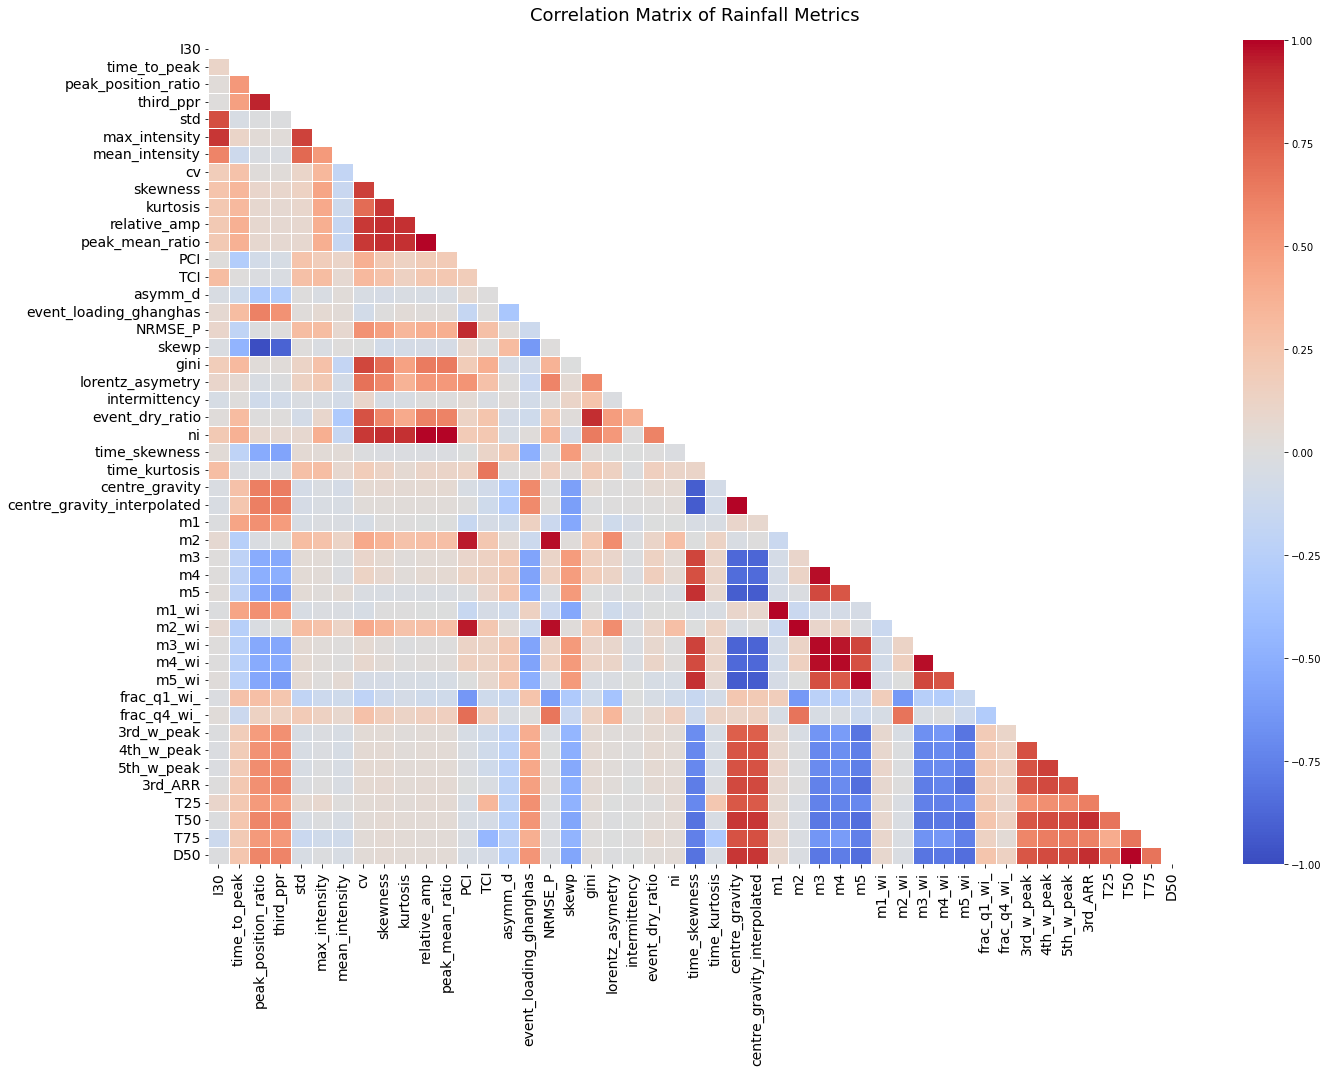

In [200]:
# 4. Plot heatmap with improved group separation and labeling
plt.figure(figsize=(20, 15))
mask = np.triu(np.ones_like(correlation_matrix_reordered, dtype=bool))

# Plot heatmap
sns.heatmap(
    correlation_matrix_reordered, mask=mask, cmap='coolwarm',
    annot=False, fmt=".2f", linewidths=0.5, cbar=True,
    xticklabels=True, yticklabels=True, annot_kws={"size": 12},
    vmin=-1, vmax=1)

# Improve layout and label size
plt.xticks(rotation=90, fontsize=14)
plt.yticks(rotation=0, fontsize=14)
plt.title("Correlation Matrix of Rainfall Metrics", fontsize=18, pad=20)
plt.tight_layout()
plt.show()


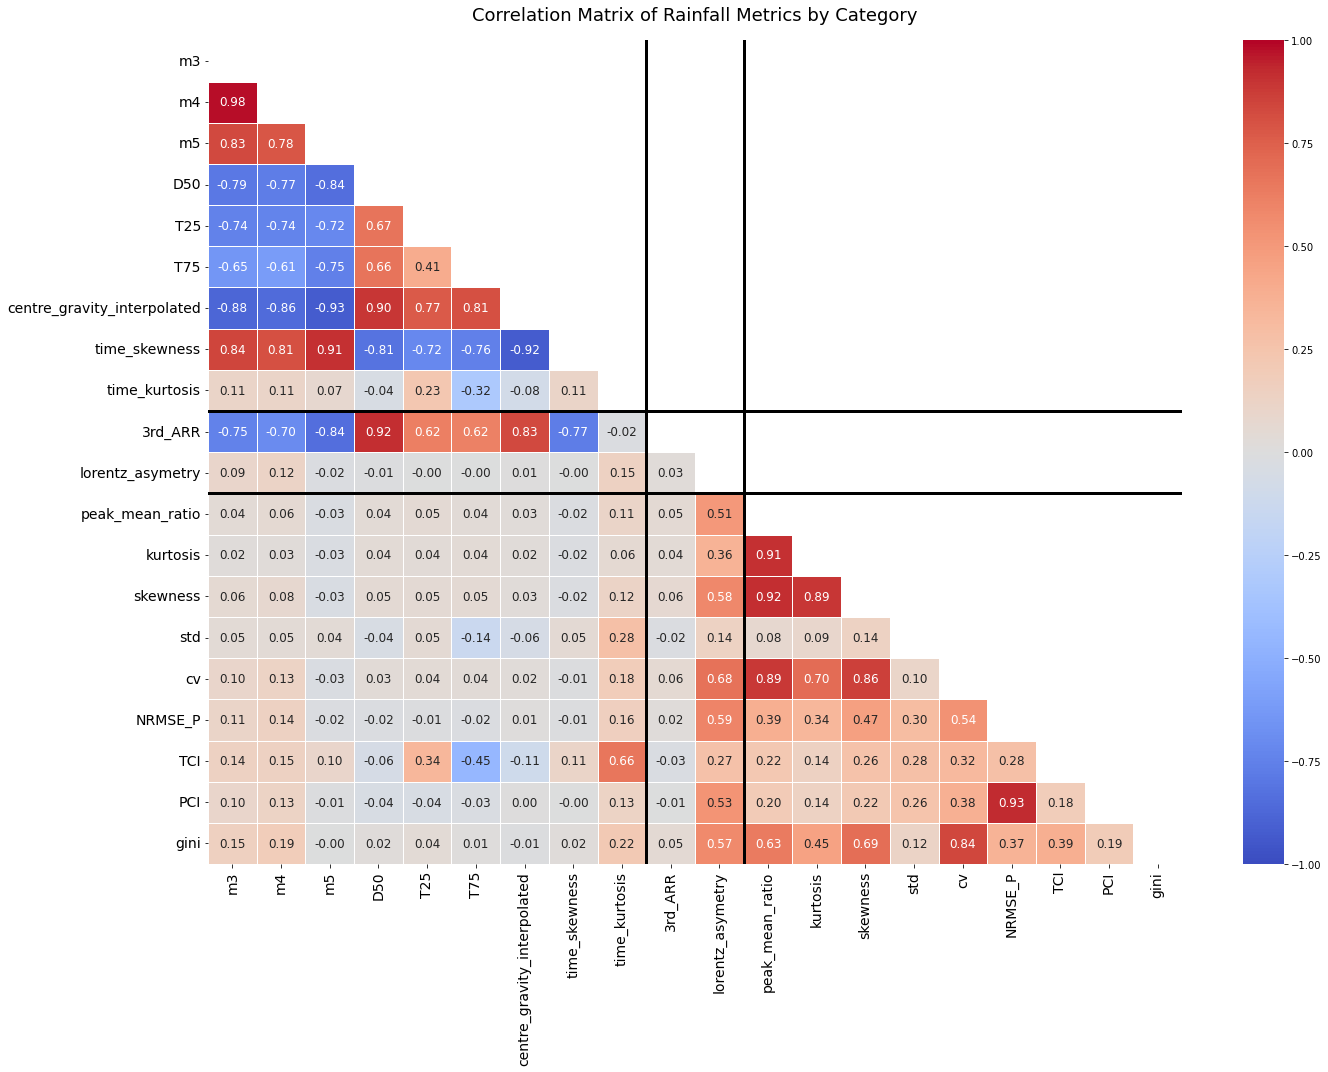


🔍 Within-group correlations:
  Peakiness      : 0.64
  Asymmetry      : 0.03
  Concentration  : 0.42

🔀 Between-group correlations:
  Peakiness  vs Asymmetry : 0.36
  Peakiness  vs Concentration: 0.08
  Asymmetry  vs Concentration: 0.25


In [148]:
# 1. Define your groups clearly
groups = {
    "Peakiness": [
        'm3', 'm4', 'm5', 'D50', 'T25', 'T75', 
        'centre_gravity_interpolated', 'time_skewness', 'time_kurtosis'
    ],
    "Asymmetry": [
#         '3rd_com',
        '3rd_ARR', 
#         'Event Loading', 
        'lorentz_asymetry', 
#         'BSC_Index'
    ],
    "Concentration": [
        'peak_mean_ratio', 'kurtosis', 'skewness', 'std', 'cv', 
        'NRMSE_P', 'TCI', 'PCI', 'gini', 
#         '% time HIZ',  '% time LIZ', '% rain HIZ'
    ]
}

# 2. Reorder the DataFrame columns based on the groups
ordered_metrics = sum(groups.values(), [])  # Flatten the list of lists
all_events_df_reordered = all_events_df[ordered_metrics]

# 3. Compute correlation matrix
correlation_matrix_reordered = all_events_df_reordered.corr()

# 4. Plot heatmap with improved group separation and labeling
plt.figure(figsize=(20, 15))
mask = np.triu(np.ones_like(correlation_matrix_reordered, dtype=bool))

# Group separators
group_sizes = [len(groups[g]) for g in groups]
group_cuts = np.cumsum([0] + group_sizes)

for cut in group_cuts[1:-1]:  # Draw lines between groups (exclude first/last)
    plt.axhline(cut, color='black', linewidth=3, zorder=10)
    plt.axvline(cut, color='black', linewidth=3, zorder=10)

# Plot heatmap
sns.heatmap(
    correlation_matrix_reordered, mask=mask, cmap='coolwarm',
    annot=True, fmt=".2f", linewidths=0.5, cbar=True,
    xticklabels=True, yticklabels=True, annot_kws={"size": 12},
    vmin=-1, vmax=1
)

# Improve layout and label size
plt.xticks(rotation=90, fontsize=14)
plt.yticks(rotation=0, fontsize=14)
plt.title("Correlation Matrix of Rainfall Metrics by Category", fontsize=18, pad=20)
plt.tight_layout()
plt.show()

# 5. Quantify within-group and between-group correlations
def mean_abs_corr(metrics1, metrics2, corr_matrix):
    values = corr_matrix.loc[metrics1, metrics2].values
    if metrics1 == metrics2:
        mask = ~np.eye(len(metrics1), dtype=bool)
        return np.mean(np.abs(values[mask]))
    else:
        return np.mean(np.abs(values))

print("\n🔍 Within-group correlations:")
for group_name, metrics in groups.items():
    score = mean_abs_corr(metrics, metrics, correlation_matrix_reordered)
    print(f"  {group_name:<15}: {score:.2f}")

print("\n🔀 Between-group correlations:")
group_names = list(groups.keys())
for i in range(len(group_names)):
    for j in range(i+1, len(group_names)):
        g1, g2 = group_names[i], group_names[j]
        score = mean_abs_corr(groups[g1], groups[g2], correlation_matrix_reordered)
        print(f"  {g1:<10} vs {g2:<10}: {score:.2f}")


(-0.45, 9.45, -0.45, 9.45)

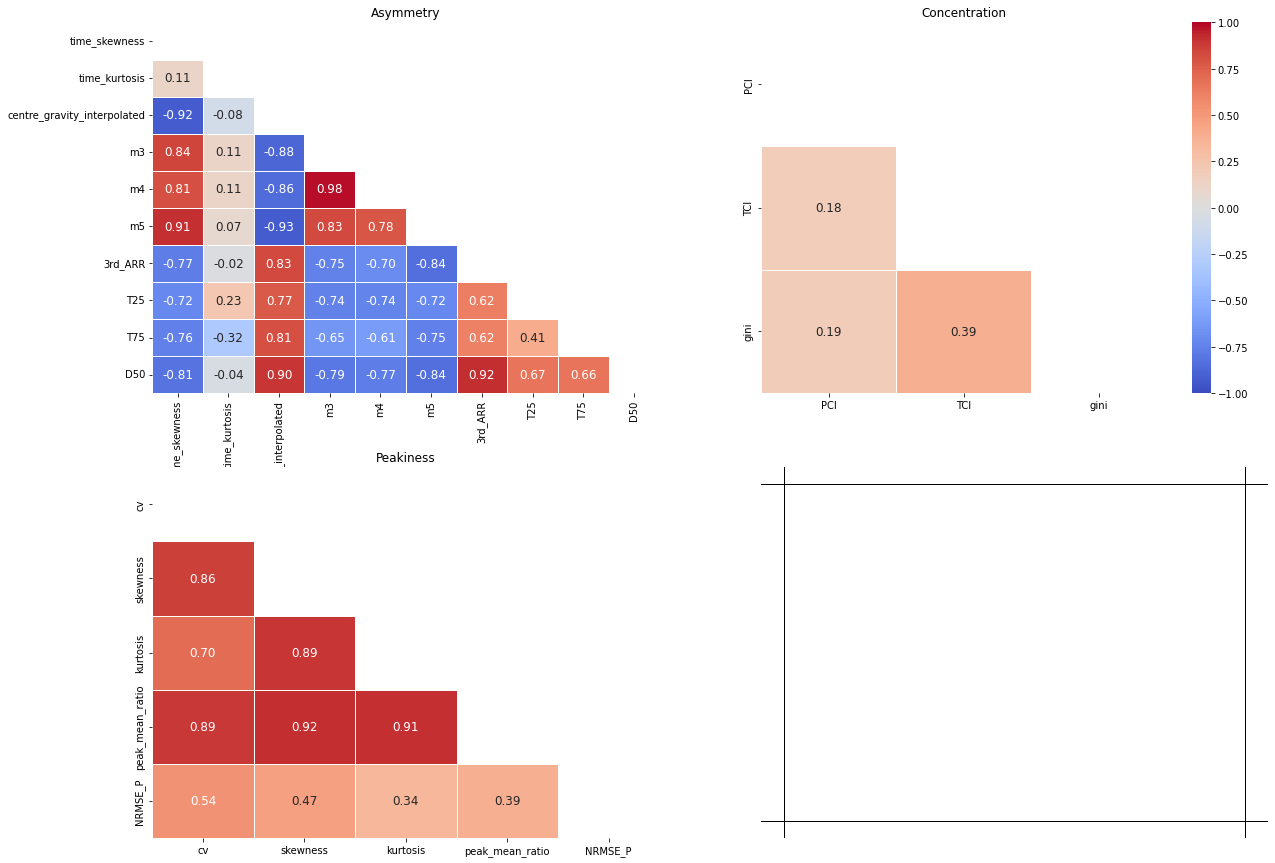

In [145]:
def plot_correlation_matrix(corr_matrix, ax, cbar, title):

    # Mask the upper triangle
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

    # Draw group separators (e.g., after every 3 variables)
    group_sizes = [0, 9, 5]  # Adjust based on your actual groupings
    group_cuts = np.cumsum(group_sizes)

    for cut in group_cuts[:-1]:  # Don't draw line after the last group
        plt.axhline(cut, color='black', linewidth=1)
        plt.axvline(cut, color='black', linewidth=1)

    # Create heatmap with annotations and larger labels
    sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm', annot=True, fmt=".2f", 
                linewidths=0.5, cbar=cbar, xticklabels=True, yticklabels=True, annot_kws={"size": 12},
                vmin=-1, vmax=1, ax=ax)  # Enforce colorbar range from -1 to 1

    # Increase the font size for axis labels
#     ax.set_xticks(rotation=90, fontsize=14)  # Rotate x-axis labels and increase font size
#     ax.set_yticks(rotation=0, fontsize=14)   # Increase y-axis label font size
    ax.set_title(title)
#     # Improve layout
#     plt.tight_layout()

fig,axs =plt.subplots(ncols=2, nrows = 2,  figsize=(20,15))
plot_correlation_matrix(correlation_matrix_asymmetry, axs[0,0], False, 'Asymmetry')
plot_correlation_matrix(correlation_matrix_concentration, axs[0,1], True, 'Concentration')
plot_correlation_matrix(correlation_matrix_peakiness, axs[1,0], False, 'Peakiness')
axs[1, 1].axis("off")


### Principal Components Analysis

In [149]:
import numpy as np
import matplotlib.pyplot as plt

### PCA 2

In [153]:
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Load the dataset
# Display the head of the dataframe to understand its structure

# Standardizing the data before PCA
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(all_events_df)

# Performing PCA
pca = PCA()
pca.fit(scaled_data)

# Explained variance ratio
explained_variance = pca.explained_variance_ratio_

# Plotting the explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o')
plt.title('Explained Variance by Principal Components')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.xticks(range(1, len(explained_variance) + 1))
plt.grid()
plt.show()

# Cumulative explained variance
cumulative_variance = explained_variance.cumsum()

ValueError: could not convert string to float: '2022-11-19 14:30:00'

In [152]:
import matplotlib.pyplot as plt

# Plotting the explained variance ratio
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.7, color='b', label='Explained Variance Ratio')
plt.plot(range(1, len(explained_variance) + 1), cumulative_variance, marker='o', color='r', label='Cumulative Explained Variance')
plt.title('PCA Explained Variance Ratio and Cumulative Explained Variance')
plt.xlabel('Principal Components')
plt.ylabel('Variance Explained')
plt.xticks(range(1, len(explained_variance) + 1))
plt.axhline(y=0.80, color='g', linestyle='--', label='80% Threshold')
plt.axhline(y=0.90, color='orange', linestyle='--', label='90% Threshold')
plt.legend()
plt.grid()
plt.show()

NameError: name 'explained_variance' is not defined

<Figure size 720x432 with 0 Axes>

In [ ]:
# Assuming we have the PCA components and the original feature names
# Let's extract the features contributing to the first 6 principal components

# Assuming pca.components_ contains the PCA components and original_feature_names is a list of feature names
# For demonstration, let's create a mock PCA components array and feature names
pca_components = pca.components_[:10]
original_feature_names = all_events_df.columns

# For now, let's create mock data for demonstration
np.random.seed(0)
# pca_components = np.random.rand(6, len(explained_variance))  # Mock PCA components for 6 components
# original_feature_names = [f'Feature {i+1}' for i in range(len(explained_variance))]  # Mock feature names

# Creating a DataFrame to show the contribution of each feature to the first 6 components
feature_contributions = pd.DataFrame(pca_components, columns=original_feature_names)
feature_contributions.index = [f'PC {i+1}' for i in range(10)]

In [ ]:
# Summarizing the most influential features for the first 6 principal components
# Finding the top contributing features for each principal component
num_top_features = 20  # Number of top features to display
summary = {}

for i in range(6):  # For each principal component
    top_features = feature_contributions.iloc[i].nlargest(num_top_features)
    summary[f'PC {i+1}'] = top_features.index.tolist()

summary_df = pd.DataFrame(summary)

# Displaying the summary of top features for each principal component
summary_df

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Drop any non-numeric or unwanted columns (e.g., identifiers)
X = all_events_df.select_dtypes(include=[float, int])

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA
pca = PCA(n_components=min(X.shape[1], 10))  # adjust number of components as needed
X_pca = pca.fit_transform(X_scaled)

# Create DataFrame of PCA results
pca_df = pd.DataFrame(X_pca, columns=[f"PC{i+1}" for i in range(X_pca.shape[1])])
pca_df.index = all_events_df.index

# Variance explained
explained_var = pca.explained_variance_ratio_

# Scree plot
plt.figure(figsize=(8, 4))
sns.barplot(x=[f"PC{i+1}" for i in range(len(explained_var))], y=explained_var)
plt.title("Explained Variance by Principal Component")
plt.ylabel("Proportion of Variance")
plt.xlabel("Principal Component")
plt.show()

# Optional: biplot or loading plot
loadings = pd.DataFrame(pca.components_.T, index=X.columns, columns=pca_df.columns)

# Plot first two PCs with loadings (biplot style)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_df["PC1"], y=pca_df["PC2"])
for i, var in enumerate(X.columns):
    plt.arrow(0, 0, loadings["PC1"][i]*2, loadings["PC2"][i]*2,
              color='r', alpha=1)
    plt.text(loadings["PC1"][i]*2.2, loadings["PC2"][i]*2.2, var, color='r')

plt.title("PCA Biplot (PC1 vs PC2)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.axhline(0, color='grey', linewidth=0.5)
plt.axvline(0, color='grey', linewidth=0.5)
plt.show()


### Correlations with moments

In [65]:
# Define your moment metrics of interest
moments = ['mean_intensity', 'std', 'kurtosis', 'skewness']
moments = [m for m in moments if m in all_events_df.columns]
print(moments)
corr_matrix, pval_matrix = corr_and_pvalues(all_events_df[5:10])

# Set up plot
fig, axs = plt.subplots(ncols=len(moments), figsize=(20,10))
vmin, vmax = -1, 1
heatmaps = []

for ax, moment in zip(axs, moments):
    # Correlations for one column
    col_corr = corr_matrix[[moment]].sort_values(by=moment, ascending=False)
    col_pval = pval_matrix[[moment]].loc[col_corr.index]

    # Annotate with asterisks for significance
    annotations = col_corr.copy()
    for i in range(len(annotations)):
        r = col_corr.iloc[i, 0]
        p = col_pval.iloc[i, 0]
        annotations.iloc[i, 0] = f"{r:.2f}" + ("*" if p < 0.05 else "")

    # Draw heatmap without colorbar
    hm = sns.heatmap(col_corr[1:], annot=annotations[1:], fmt="", cmap='coolwarm',
                     vmin=vmin, vmax=vmax, ax=ax, cbar=False, linewidths=0.5,
                     linecolor='lightgray', annot_kws={"size": 10})

    ax.set_title(f'Correlation with {moment}')
    heatmaps.append(hm)

# Add shared colorbar
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
fig.colorbar(heatmaps[-1].collections[0], cax=cbar_ax)
plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()


['mean_intensity', 'std', 'kurtosis', 'skewness']


/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/ukcp18/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


UFuncTypeError: ufunc 'add' did not contain a loop with signature matching types (dtype('<U32'), dtype('<U32')) -> dtype('<U32')